In [1]:
import csv
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, roc_curve, precision_recall_curve, auc  
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import datetime
from random import randint
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/rashi/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['randint']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Checking if pandas can read saved csv properly
df_cgms = pd.read_csv('data/DataTables/modified_cgms.csv', sep=',', header=None)
# data table actually exists a directory above the views.py file
df_cgms.columns = df_cgms.iloc[0]
# Use first row info as header
df_cgms.drop(df_cgms.index[0], inplace=True)
# Drop first row
df_cgms.drop(df_cgms.columns[[0]], axis=1, inplace=True)
# removing the first column of NaNs that shows up from reading csv. Don't ask why. Sigh.
df_cgms.drop(['MeterBG', 'Diff'], axis=1, inplace=True)
# dropping these to get rid of unnecessary NaNs

df_cgms['SensorGLU'] = pd.to_numeric(df_cgms['SensorGLU'])
df_cgms['ExBG'] = pd.to_numeric(df_cgms['ExBG'])
df_cgms['Episode'] = pd.to_numeric(df_cgms['Episode'])
df_cgms['ExStat'] = pd.to_numeric(df_cgms['ExStat'])


df_cgms.tail()

,PtID,GVisitType,ReadingDt,ReadingTm,SensorGLU,ExBG,ExStat,BeforeEx,AfterEx,Episode
14955,52,Basal stopped,2000-01-18,18:15,117,NaN,0,117,117,0
14956,52,Basal stopped,2000-01-18,18:20,117,156.0,0,117,117,0
14957,52,Basal stopped,2000-01-18,18:25,119,NaN,0,119,119,0
14958,52,Basal stopped,2000-01-18,18:30,125,NaN,0,125,125,0
14959,52,Basal stopped,2000-01-18,18:35,134,191.0,0,134,134,0


In [3]:
df_cgms.describe()

,SensorGLU,ExBG,ExStat,Episode
count,14959.000000,2107.000000,14959.000000,14959.000000
mean,157.379237,143.121974,0.034427,0.005749
std,69.249943,58.191393,0.182330,0.075607
min,40.000000,38.000000,0.000000,0.000000
25%,109.000000,99.000000,0.000000,0.000000
50%,141.000000,135.000000,0.000000,0.000000
75%,193.000000,175.000000,0.000000,0.000000
max,400.000000,488.000000,1.000000,1.000000


In [4]:
# Printing out unique patients in dataset
patients_cgms = np.sort(np.unique(df_cgms['PtID'].astype(int)))
print(patients_cgms, len(patients_cgms))

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 51 52
 53 54 55 56 57] 55


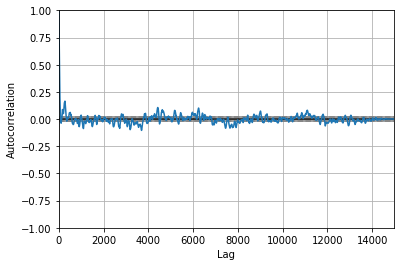

In [5]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df_cgms['SensorGLU'])

Text(0.5,0,'Time (min)')

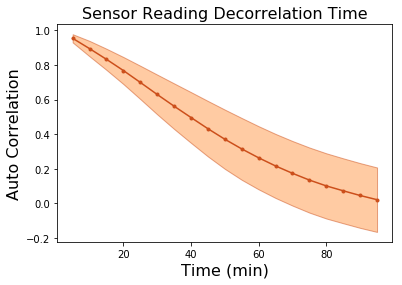

In [18]:
from tsfresh.feature_extraction.feature_calculators import autocorrelation

auto = []; error = []
for j in range(1,20):
    auto_i = []
    for i in range(2,56):    
        df = df_cgms[df_cgms['PtID'] == str(i)]
        df_sens = df[df['GVisitType'] == "Basal stopped"]
        auto_i.append(autocorrelation(df_sens['SensorGLU'], j))
        
        df_sens = df[df['GVisitType'] == "Basal continued"]
        auto_i.append(autocorrelation(df_sens['SensorGLU'], j))
    auto.append(np.nanmean(auto_i))
    error.append(np.nanstd(auto_i))
    
x = 5*np.arange(1,20)
y = auto
error = np.array(error)/2
plot(x, y, 'k.-', color='#CC4F1B')
fill_between(x, y-error, y+error,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')

#errorbar(5*np.arange(1,20), auto, yerr=np.array(error)/2)
title('Sensor Reading Decorrelation Time', fontsize=16)
ylabel('Auto Correlation', fontsize=16)
xlabel('Time (min)', fontsize=16)

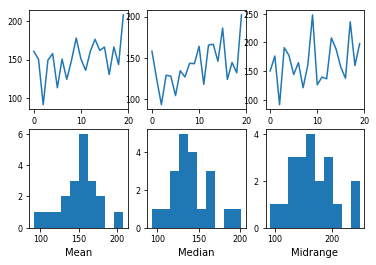

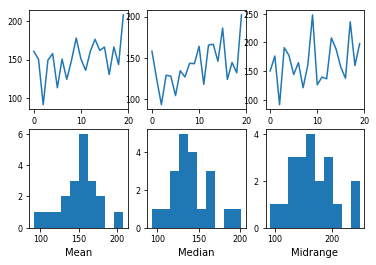

In [7]:
from pandas.plotting import bootstrap_plot

bootstrap_plot(df_cgms['SensorGLU'], size=10, samples=20)

## Checking Insulin dependencies

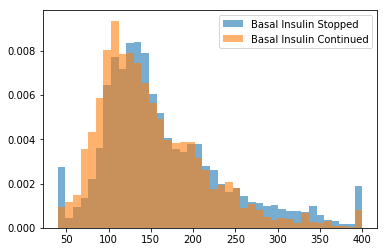

In [8]:
# SENSOR GLUCOSE READING HISTOGRAMS FOR INSULIN DATA

df_stopped = df_cgms[df_cgms['GVisitType'] == "Basal stopped"]
df_continued = df_cgms[df_cgms['GVisitType'] == "Basal continued"]

sensor_stopped = df_stopped.iloc[:,4].values
sensor_continued = df_continued.iloc[:,4].values
# Sensor Readings

kwargs = dict(histtype='stepfilled', alpha=0.6, normed=True, bins=40)

plt.hist(sensor_stopped, **kwargs, label='Basal Insulin Stopped')
plt.hist(sensor_continued, **kwargs, label='Basal Insulin Continued')
plt.legend()


/home/rashi/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/rashi/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


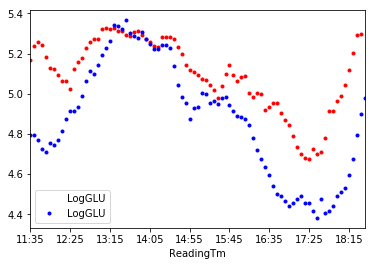

In [9]:
df1 = df_stopped[df_stopped['PtID'] == '32']
df1['LogGLU'] = np.log(df1['SensorGLU'])
df2 = df_continued[df_continued['PtID'] == '32']
df2['LogGLU'] = np.log(df2['SensorGLU'])

ax = df1.plot(x="ReadingTm",y="LogGLU",style='r.')
df2.plot(x="ReadingTm",y="LogGLU",style='b.',ax=ax)


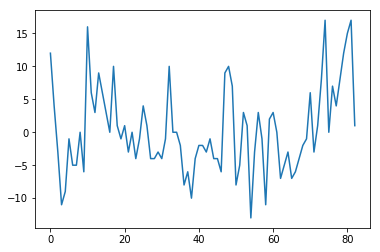

In [10]:
plot(diff(df1['SensorGLU']))
# Stationary?

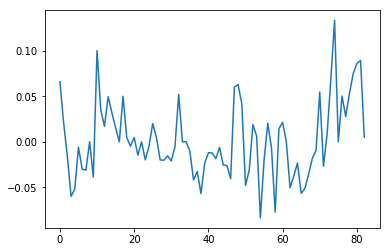

In [11]:
plot(diff(df1['LogGLU']))
# Kinda stationary

## Checking dependencies of hypo episodes

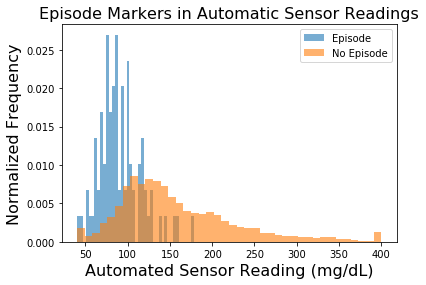

In [12]:
# SENSOR GLUCOSE READING HISTOGRAMS 

df_yes = df_cgms[df_cgms['Episode'] == 1]
df_no = df_cgms[df_cgms['Episode'] == 0]

yes = df_yes.iloc[:,4].values
no = df_no.iloc[:,4].values
# Sensor Readings

kwargs = dict(histtype='stepfilled', alpha=0.6, normed=True, bins=40)

plt.hist(yes, **kwargs, label='Episode')
plt.hist(no, **kwargs, label='No Episode')

plt.title('Episode Markers in Automatic Sensor Readings', fontsize=16)
ylabel("Normalized Frequency", fontsize=16)
xlabel("Automated Sensor Reading (mg/dL)", fontsize=16)
plt.legend()


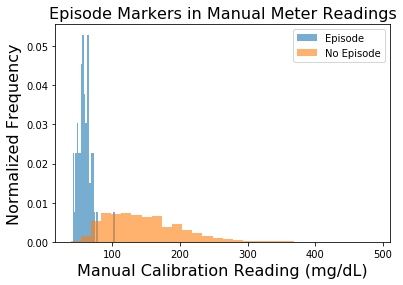

In [13]:
df_dropna = df_cgms.dropna(axis=0, how='any')
# DOESN'T MAKE SENSE to rely on Manual Meter data only, as hypo events are sometimes missing meter readings

dropna_yes = df_dropna[df_dropna['Episode'] == 1]
dropna_no = df_dropna[df_dropna['Episode'] == 0]

yes_manual = dropna_yes.iloc[:,5].values
no_manual = dropna_no.iloc[:,5].values
# Manual Meter Readings

kwargs = dict(histtype='stepfilled', alpha=0.6, normed=True, bins=30)

plt.hist(yes_manual, **kwargs, label='Episode')
plt.hist(no_manual, **kwargs, label='No Episode')

title('Episode Markers in Manual Meter Readings', fontsize=16)
ylabel("Normalized Frequency", fontsize=16)
xlabel("Manual Calibration Reading (mg/dL)", fontsize=16)
plt.legend()

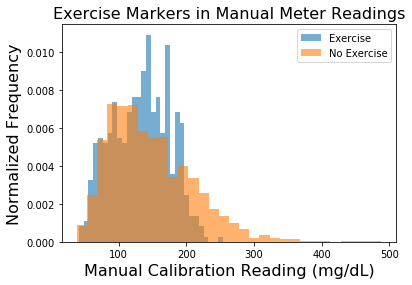

In [14]:
# Check trend of BG with and without exercise

ex_yes = df_dropna[df_dropna['ExStat'] == 1]
ex_no = df_dropna[df_dropna['ExStat'] == 0]

ex_yes_manual = ex_yes.iloc[:,5].values
ex_no_manual = ex_no.iloc[:,5].values
# Manual Meter Readings

kwargs = dict(histtype='stepfilled', alpha=0.6, normed=True, bins=30)

plt.hist(ex_yes_manual, **kwargs, label='Exercise')
plt.hist(ex_no_manual, **kwargs, label='No Exercise')

title('Exercise Markers in Manual Meter Readings', fontsize=16)
ylabel("Normalized Frequency", fontsize=16)
xlabel("Manual Calibration Reading (mg/dL)", fontsize=16)
plt.legend()

In [15]:
from scipy.signal import argrelextrema

df_stopped = df_cgms[df_cgms['GVisitType'] == "Basal stopped"]
df_continued = df_cgms[df_cgms['GVisitType'] == "Basal continued"]

sens_stop = df_stopped[df_stopped['PtID'] == 26].iloc[:,4].values
sens_cont = df_continued[df_continued['PtID'] == 26].iloc[:,4].values
# Sensor Readings

sens_cont[argrelextrema(sens_cont, np.greater_equal)]

array([], dtype=int64)

In [16]:
from scipy.signal import find_peaks_cwt

df_stopped = df_cgms[df_cgms['GVisitType'] == "Basal stopped"]
df_continued = df_cgms[df_cgms['GVisitType'] == "Basal continued"]

sens_stop = df_stopped[df_stopped['PtID'] == 26].iloc[:,4].values
sens_cont = df_continued[df_continued['PtID'] == 26].iloc[:,4].values
# Sensor Readings

#indexes = find_peaks_cwt(sens_stop, np.arange(1, 550))
#indexes = find_peaks_cwt(sens_cont, np.arange(1, 550))